In [1]:
import sympy as sp
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import odeint
import control as ct  # If not installed --> pip install control

plt.style.use('../maroon_ipynb.mplstyle')

\pagebreak
\tableofcontents
\pagebreak

# Problem
Solve $25\ddot{x}_0+5\dot{x}_0+150x_0=100e^{-5t}$ using several different ways. The initial conditions are zero.

## Analytical Solution

In [2]:
t = sp.Symbol('t')
x0 = sp.Function('x_0')(t)
eq = sp.Eq(25*x0.diff(t, 2) + 5*x0.diff() + 150*x0, 100*sp.exp(-5*t))
eq

Eq(150*x_0(t) + 5*Derivative(x_0(t), t) + 25*Derivative(x_0(t), (t, 2)), 100*exp(-5*t))

In [3]:
sol = sp.dsolve(eq, ics={
    x0.subs(t, 0): 0,
    x0.diff().subs(t, 0): 0
})
sol

Eq(x_0(t), (98*sqrt(599)*sin(sqrt(599)*t/10)/8985 - 2*cos(sqrt(599)*t/10)/15)*exp(-t/10) + 2*exp(-5*t)/15)

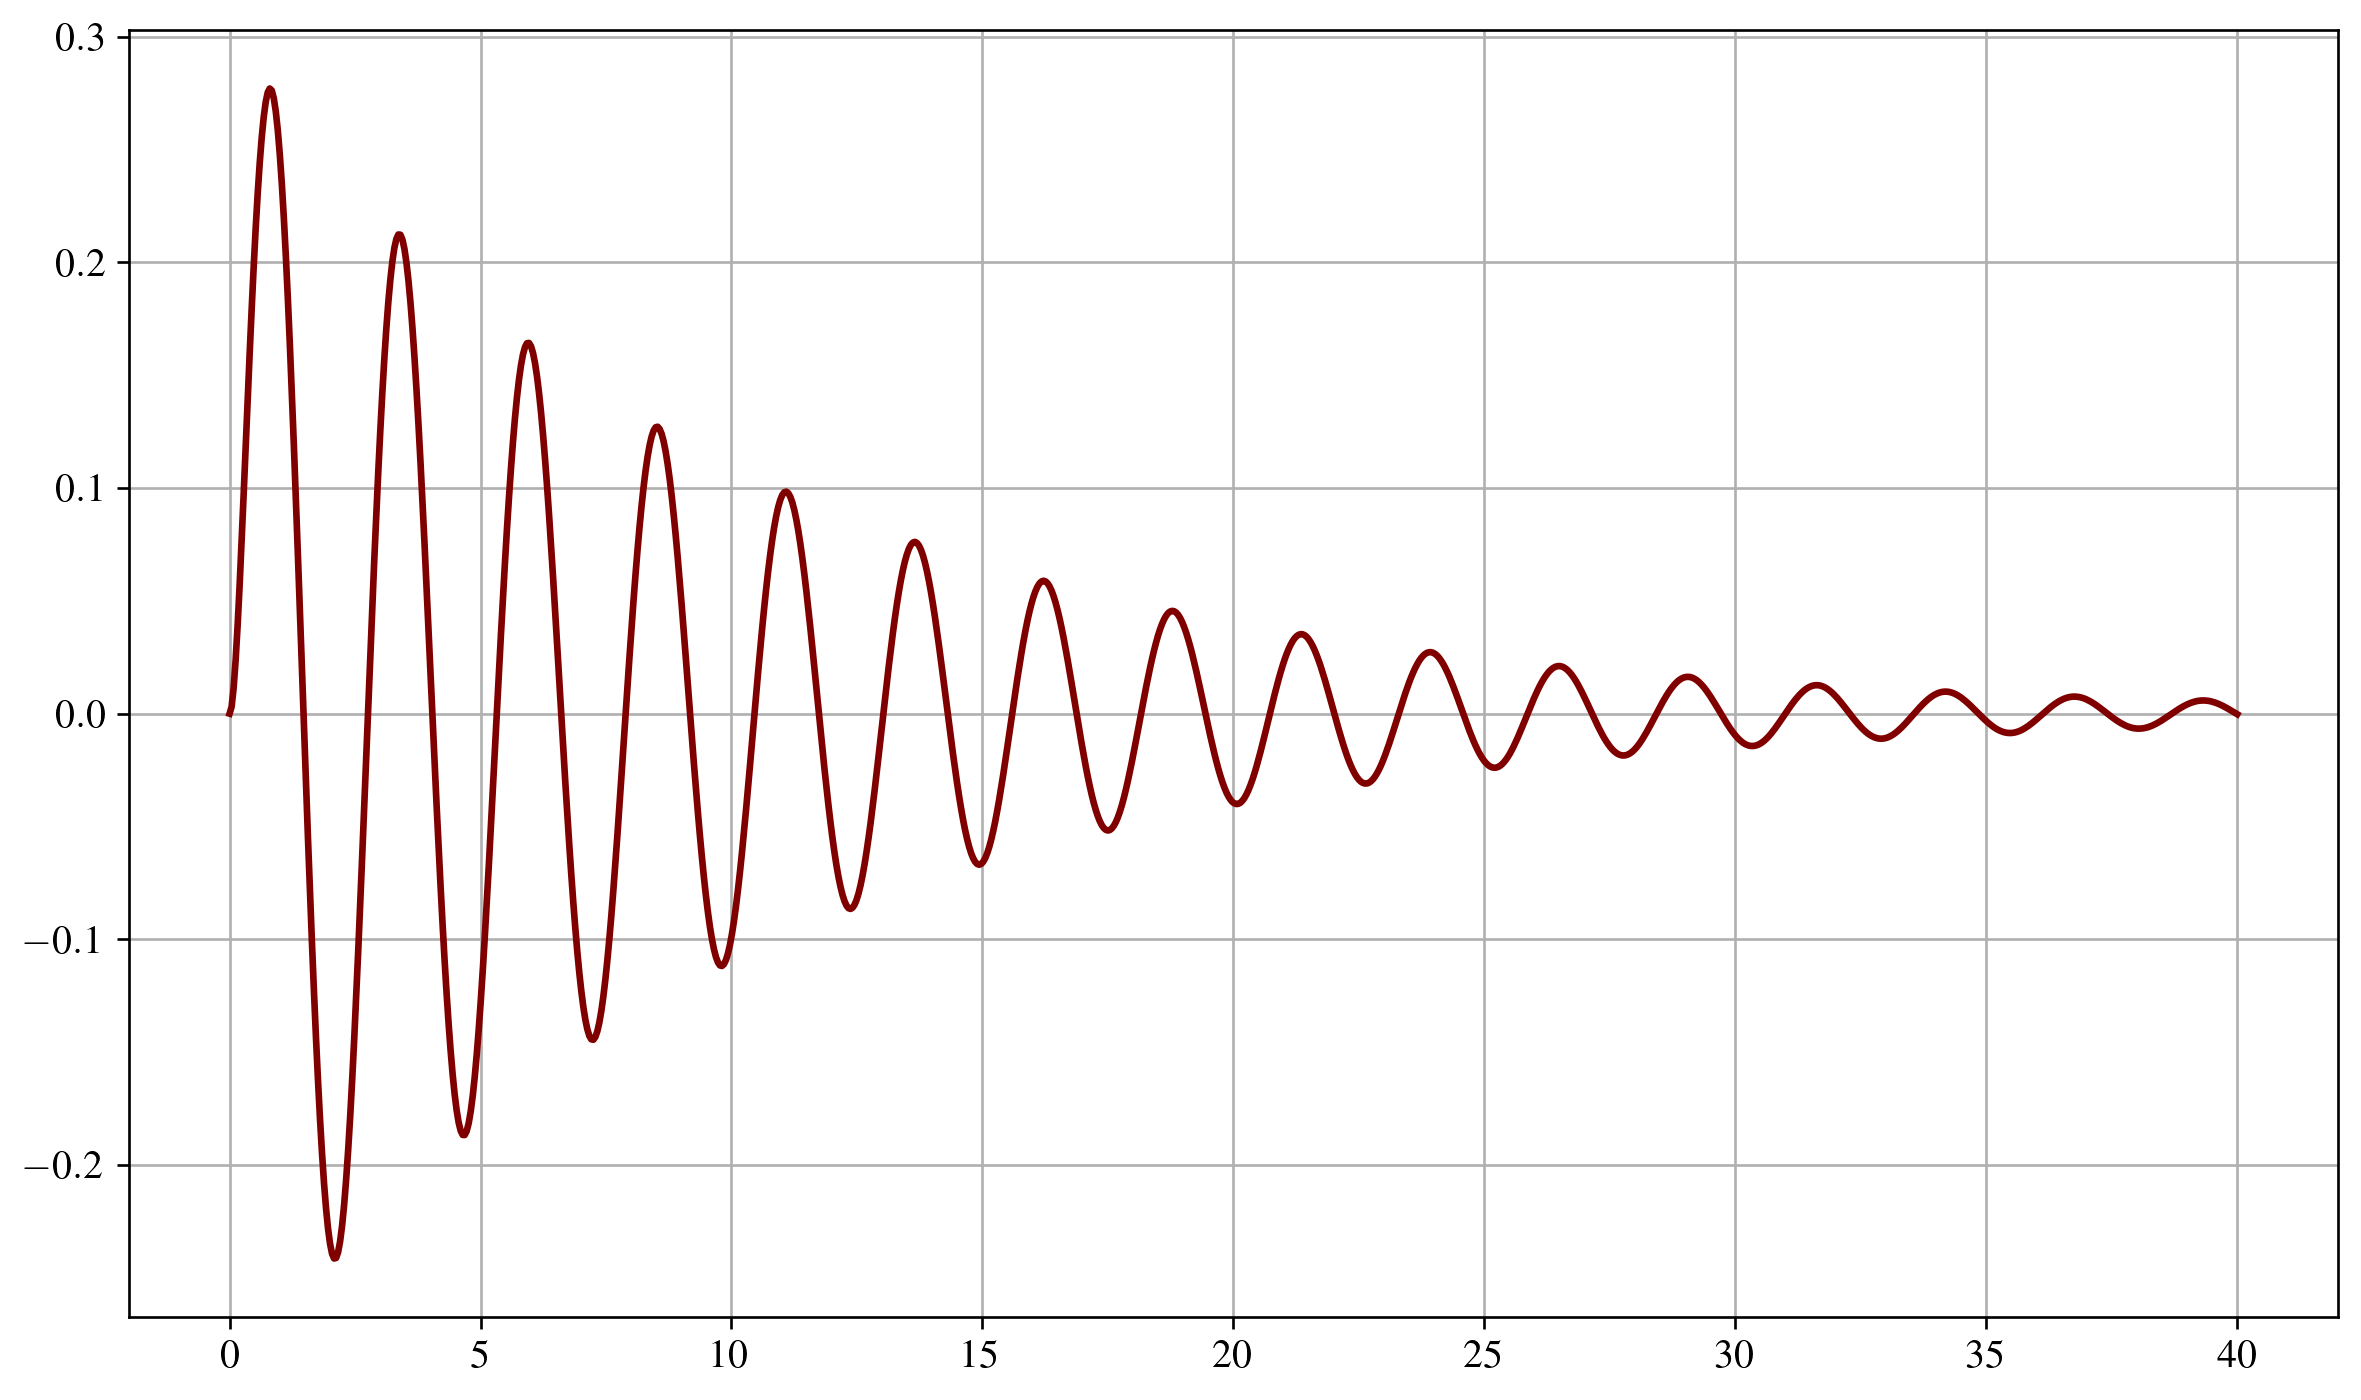

In [4]:
x0_lamb = sp.lambdify(t, sol.rhs, modules='numpy')
x1_lamb = sp.lambdify(t, sol.rhs.diff(), modules='numpy')
time_array = np.linspace(0, 40, 1000)
plt.plot(time_array, x0_lamb(time_array))
plt.show()

## State Variable Solution

In [5]:
# Getting it into the state variable form symbolically
x1 = sp.Function('x_1')(t)

eq1 = sp.Eq(x0.diff(), x1)
subs = [
    (x0.diff(t, 2), x1.diff()),
    (x0.diff(), x1)
]
eq2 = eq.subs(subs)

state_sol = sp.solve([eq1, eq2], [x0.diff(), x1.diff()], dict=True)[0]
for key, value in state_sol.items():
    display(sp.Eq(key, value))

Eq(Derivative(x_0(t), t), x_1(t))

Eq(Derivative(x_1(t), t), -6*x_0(t) - x_1(t)/5 + 4*exp(-5*t))

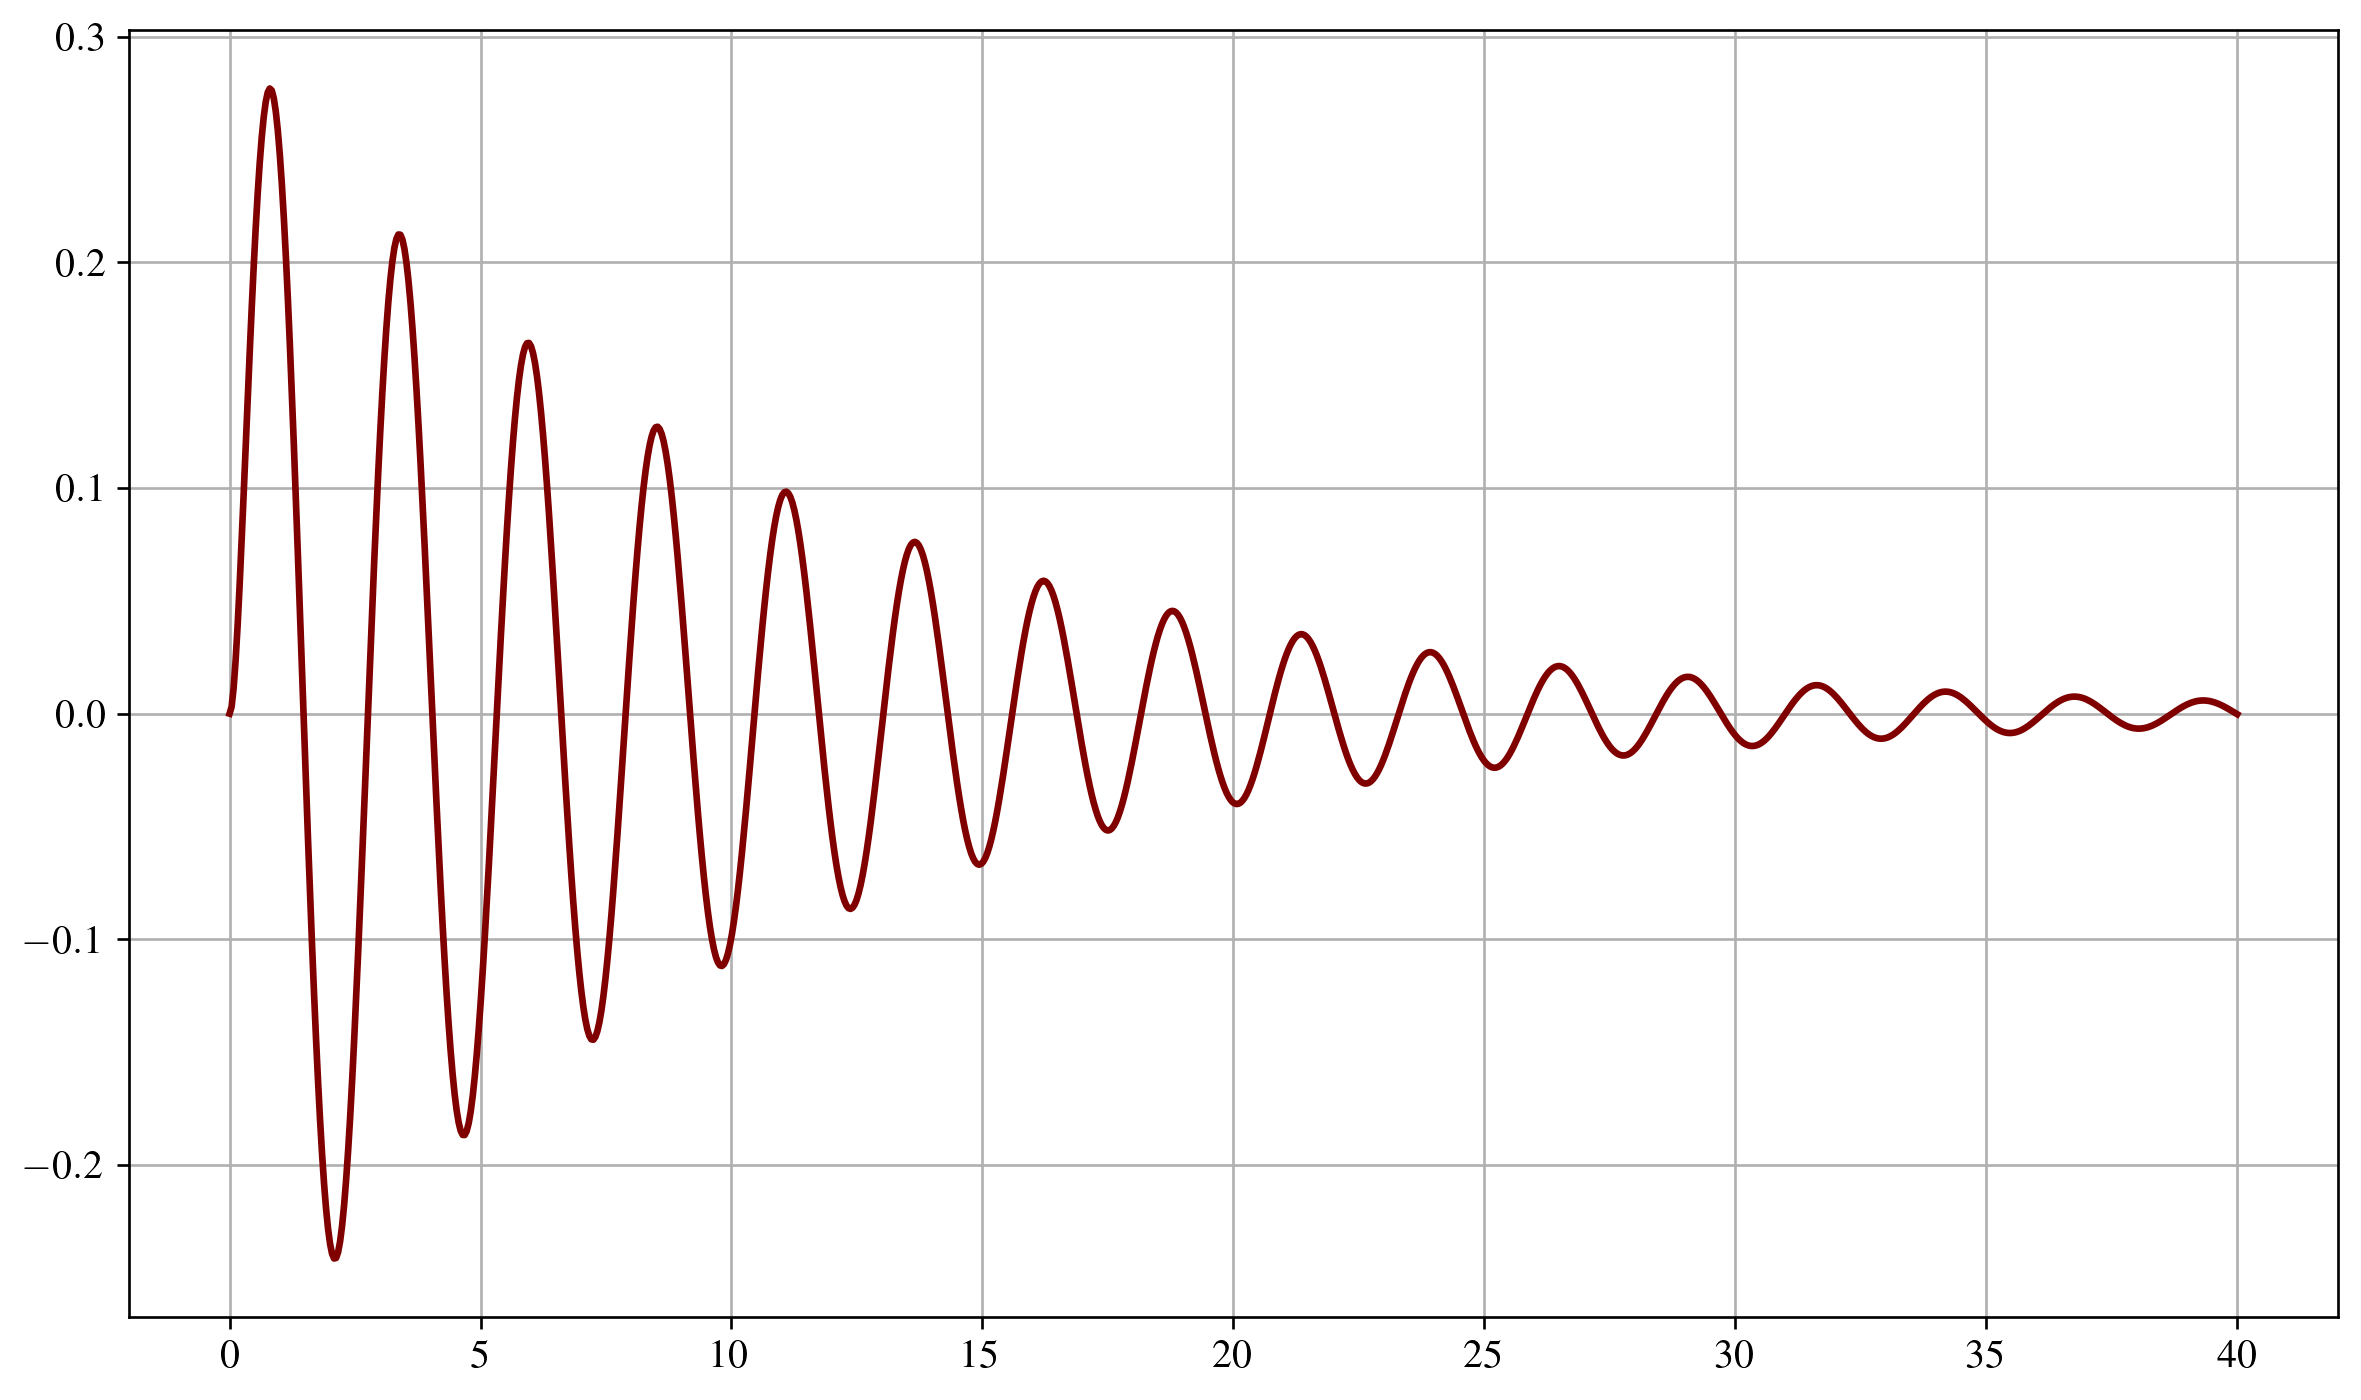

In [6]:
def state_vars(x, t_):
    return [
        x[1],
        1/25*(100*np.exp(-5*t_) - 150*x[0] - 5*x[1])
    ]

sol = odeint(state_vars, (0, 0), time_array)
x_0 = sol[:, 0]
plt.plot(time_array, x_0)
plt.show()

## Transfer Function Solution

In [7]:
# Getting the transfer function symbolically
s = sp.Symbol('s')
f = sp.Function('f')(t)
eq_s = sp.Eq(
    sp.laplace_transform(eq.lhs, t, s)[0],
    sp.laplace_transform(f, t, s)[0]
)
eq_s

Eq(25*s**2*LaplaceTransform(x_0(t), t, s) + 5*s*LaplaceTransform(x_0(t), t, s) - 25*s*x_0(0) + 150*LaplaceTransform(x_0(t), t, s) - 5*x_0(0) - 25*Subs(Derivative(x_0(t), t), t, 0), LaplaceTransform(f(t), t, s))

In [8]:
# Initial conditions for transfer functions are always zero
eq_s = eq_s.subs([
    (x0.subs(t, 0), 0),
    (x0.diff().subs(t, 0), 0)
])
eq_s

Eq(25*s**2*LaplaceTransform(x_0(t), t, s) + 5*s*LaplaceTransform(x_0(t), t, s) + 150*LaplaceTransform(x_0(t), t, s), LaplaceTransform(f(t), t, s))

In [9]:
sp.solve(eq_s, sp.laplace_transform(x0, t, s)[0])[0]

LaplaceTransform(f(t), t, s)/(5*(5*s**2 + s + 30))

In [10]:
# Note: do not call the transfer function object 'sys'.
T = ct.tf(1, [25, 5, 150])
T

TransferFunction(array([1]), array([ 25,   5, 150]))

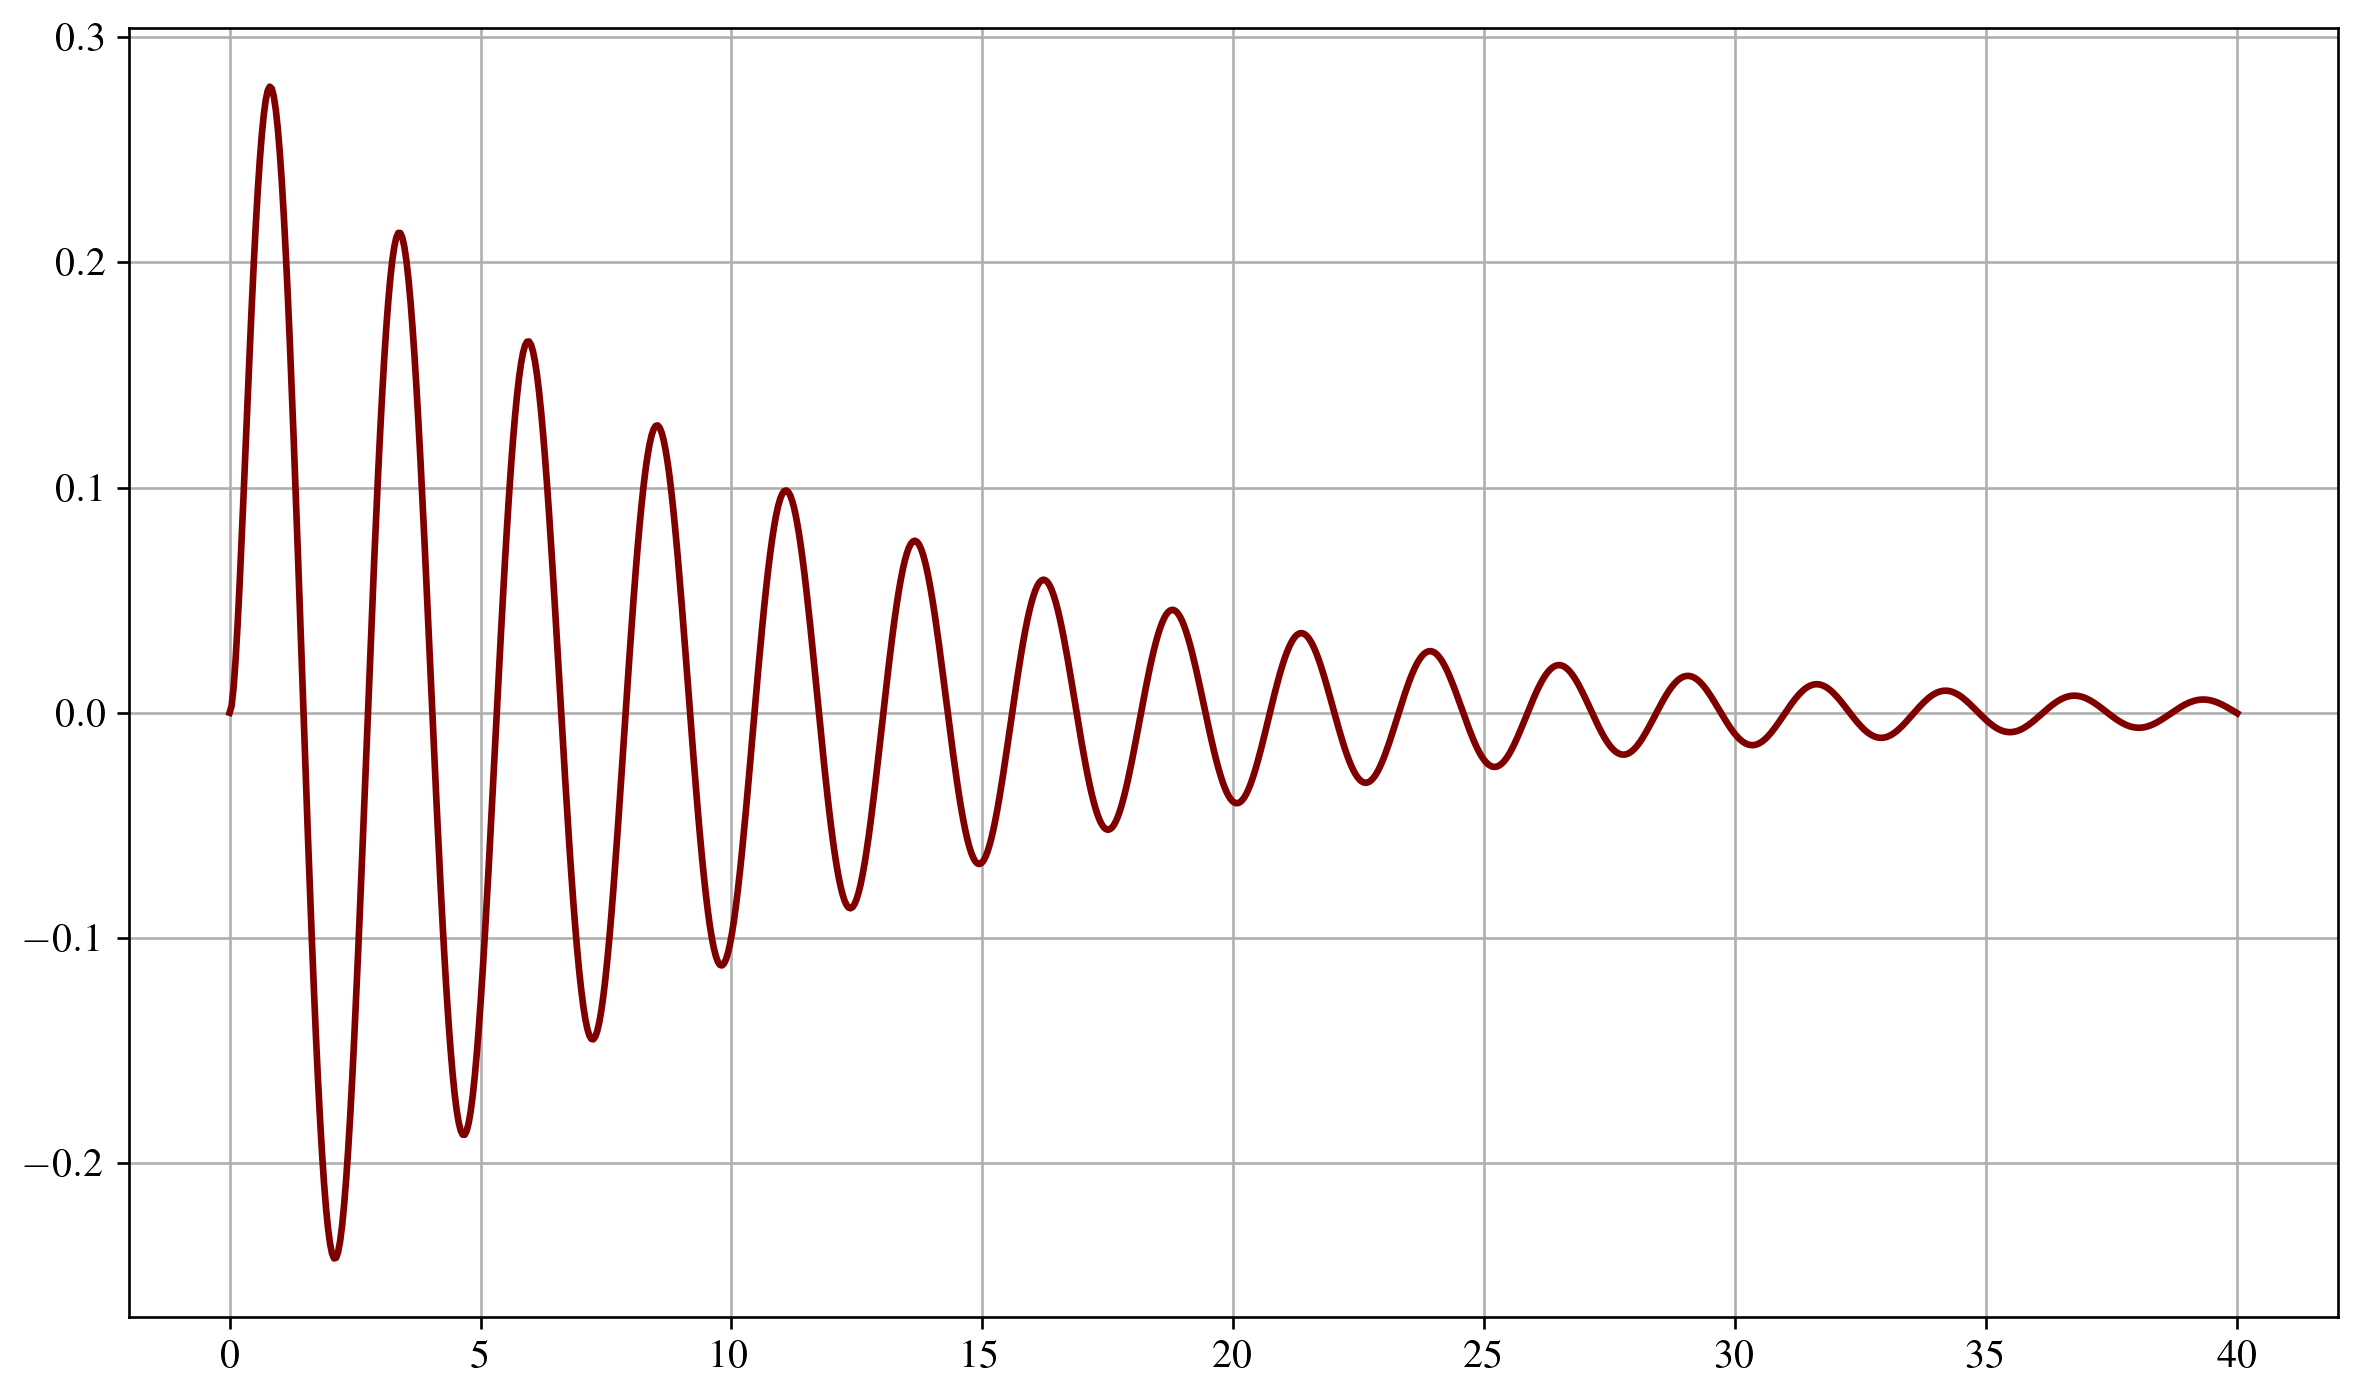

In [11]:
_, x_0 = ct.forced_response(T, T=time_array, U=100*np.exp(-5*time_array))  # returns a tuple containing the time array and the response

plt.plot(time_array, x_0)
plt.show()

## State Space Model
If your model has initial conditions, and you would like to use the control package, use the state space model over the transfer function model.

In [12]:
A = [
    [0, 1],
    [-6, -0.2]
]

B = [
    [0],
    [1/25]
]

C = [
    [1, 0],
    [0, 1]
]

D = [
    [0],
    [0]
]

ss = ct.ss(A, B, C, D)
ss

<LinearIOSystem:sys[4]:['u[0]']->['y[0]', 'y[1]']>

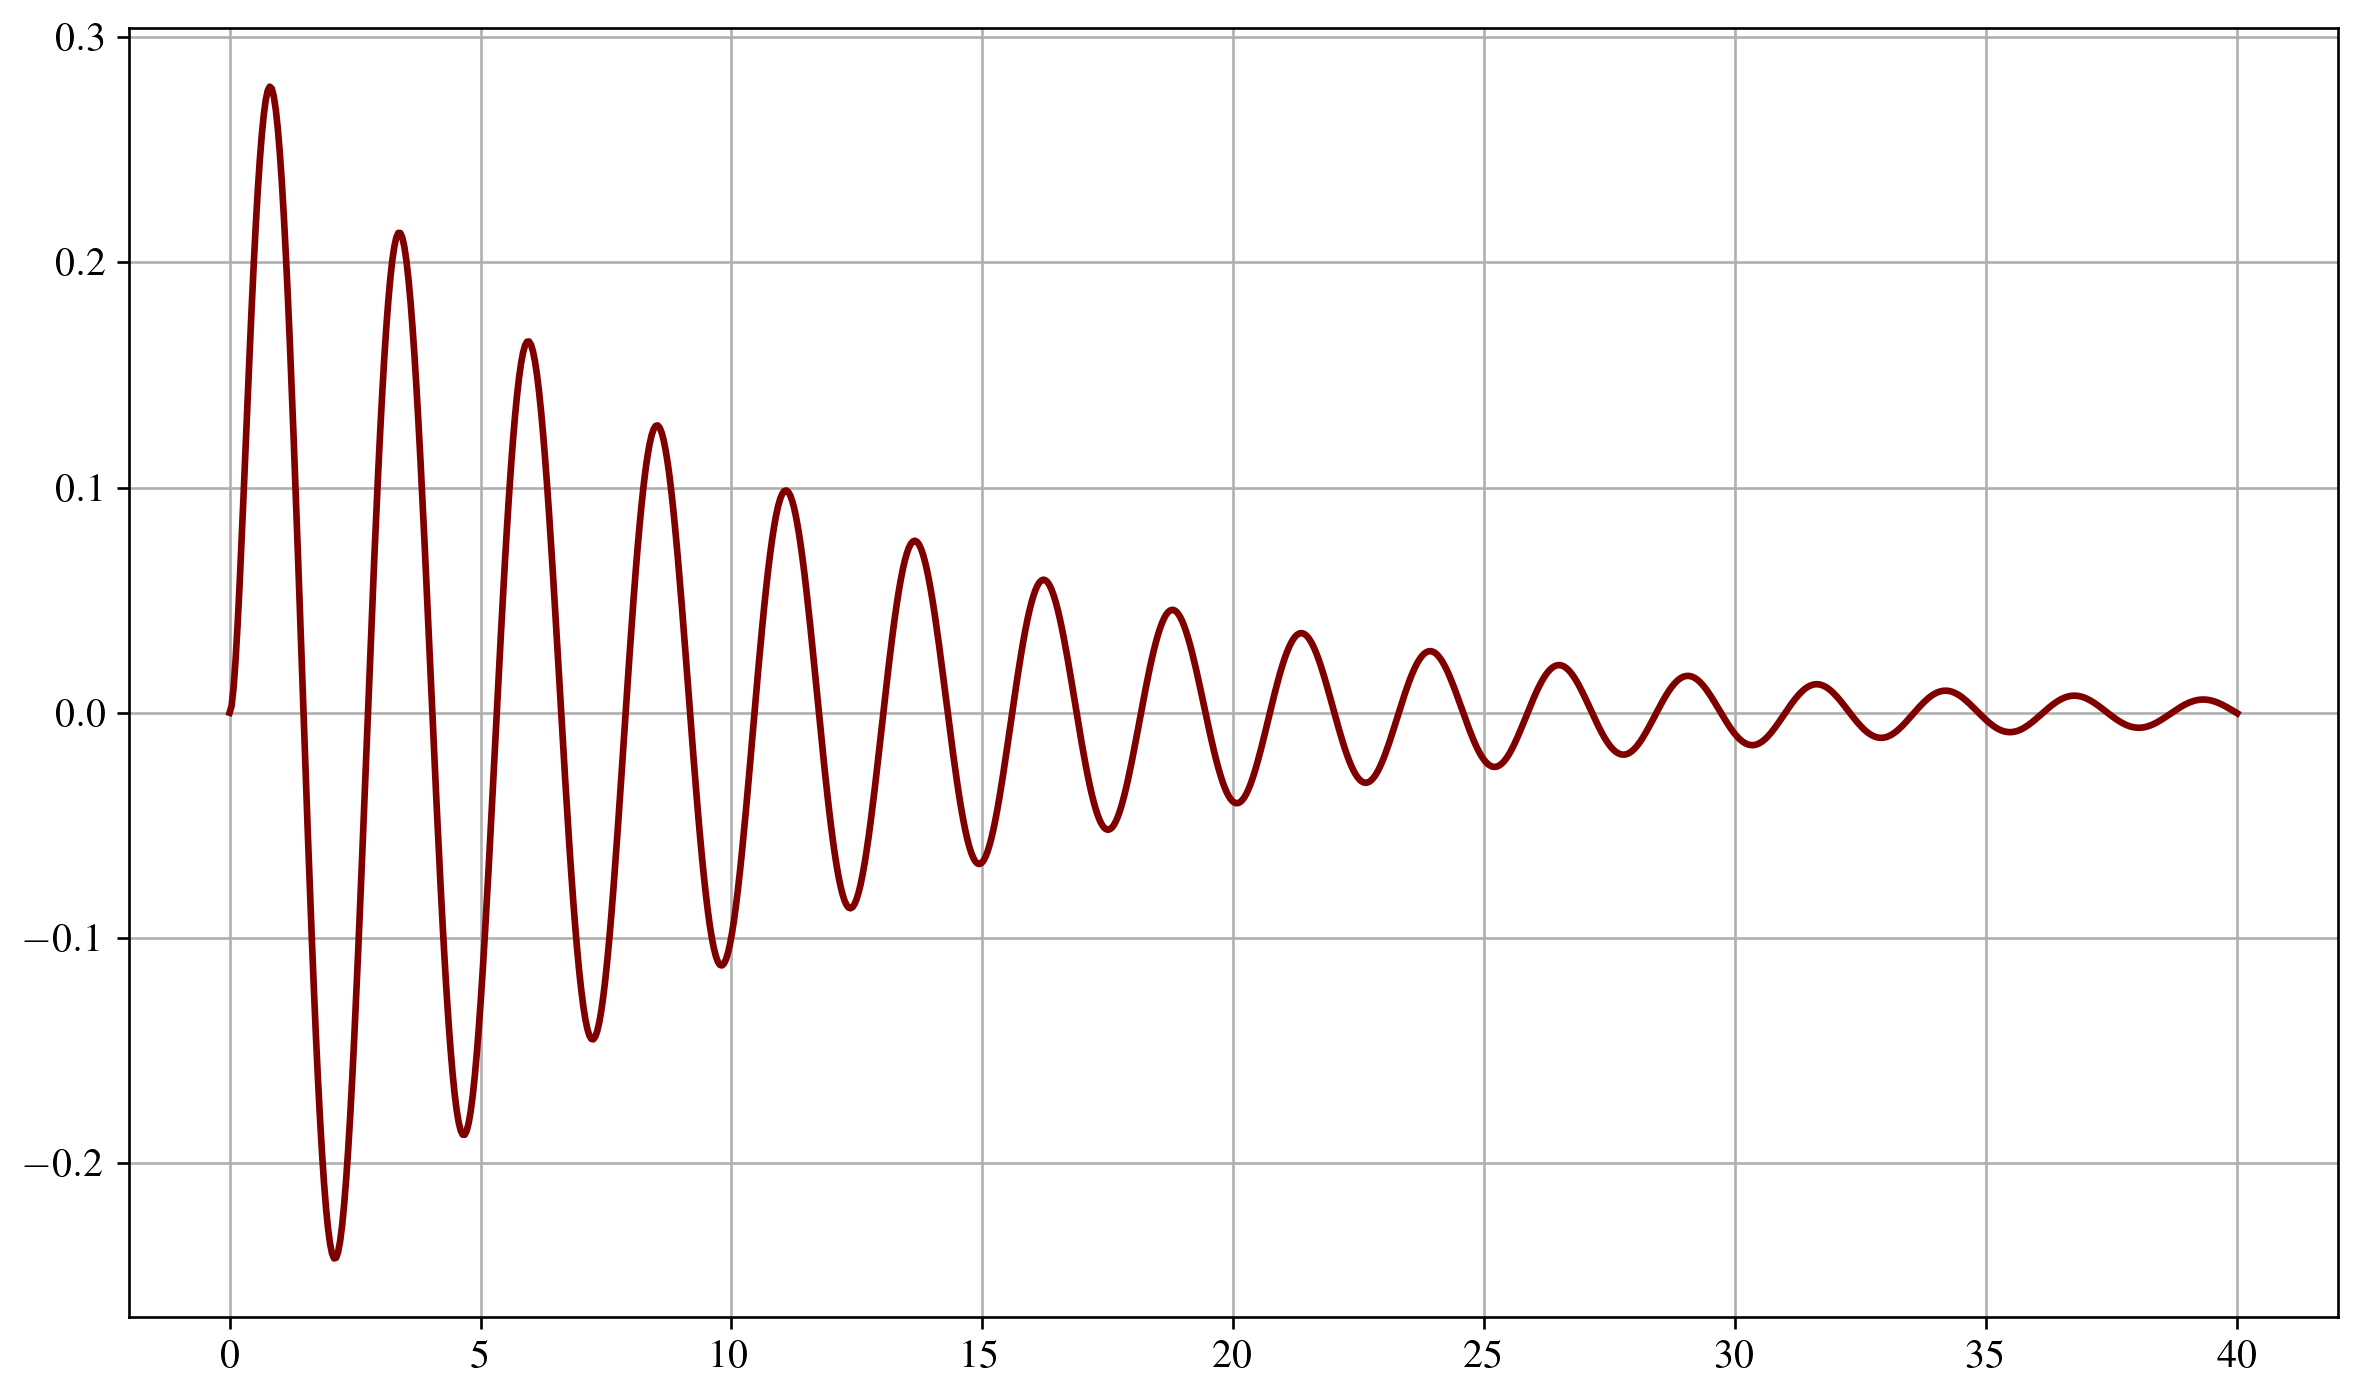

In [13]:
_, sol = ct.forced_response(ss, T=time_array, U=100*np.exp(-5*time_array))  # returns a tuple containing the time array and the response
plt.plot(time_array, sol[0])

# Velocity
# vel_ax = plt.twinx()
# vel_ax.plot(time_array, sol[1], color='black', ls='--')
# vel_ax.plot(time_array, x1_lamb(time_array))
# vel_ax.grid(False)

# For initial conditions if x(0) = 0.1 and x_dot(0) = 0
# _, x_free = ct.initial_response(sys1, T=time_array, X0=(0.1, 0))
# plt.plot(time_array, sol[0] + x_free[0])

# or you can do initial conditions all at once rather than doing forced response + free response
# _, sol = ct.forced_response(sys1, T=time_array, U=100*np.exp(-5*time_array), X0=(0.1, 0))
# plt.plot(time_array, sol[0])

plt.show()